In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
from sklearn.metrics import roc_curve, auc

from sklearn import svm

In [36]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

In [37]:
directory='c:/users/da1933/desktop/cds/ids_project/'
#directory='~/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

In [38]:
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)
df['price']=df['price'].fillna(np.mean(df['price']))
df['price']=scale(df[['price']])
df['designation']=df['designation'].fillna('missing')
df['textlen']=df['description'].apply(lambda x: len(x))
df['textlen']=scale(df[['textlen']])

### Embeddings  - building out categorical embeddings from:  
* https://www.fast.ai/2018/04/29/categorical-embeddings/
* https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-4-2048a26d58aa
* https://forums.fast.ai/t/understanding-columnarmodeldata-from-data-frame-from-rossman/8140

In [ ]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F

In [57]:
df.dtypes.value_counts()

object     8
int32      3
float64    2
int64      2
dtype: int64

In [59]:
cat_vars = [col for col in df if df[col].dtype.name != 'float64' and df[col].dtype.name != 'float32' and len(df[col].unique()) < 1500]
cat_vars.remove('over90')
cat_vars.remove('points')
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]

In [60]:
cat_sz

[('country', 51),
 ('province', 491),
 ('region_1', 1333),
 ('region_2', 19),
 ('variety', 757),
 ('enc_country', 52),
 ('enc_province', 492),
 ('enc_variety', 758)]

### Encoding

In [42]:
l_enc = LabelEncoder()
col1 = l_enc.fit_transform(df['country'].astype(str))
col2 = l_enc.fit_transform(df['variety'].astype(str))
col3 = l_enc.fit_transform(df['province'].astype(str))
df_enc = pd.DataFrame({'enc_country':col1,'enc_variety':col2,'enc_province':col3})

df=pd.concat([df,df_enc],axis=1)

#one hot encoding
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)

X_enc

### Train-Test-Split

In [43]:
df=df.set_index(np.random.permutation(df.index.values)).sort_index()

# Determine split index:
split_index=int(np.round(df.shape[0]*.8))

# Assign training and testing datasets based on split index
train_df=df.iloc[:split_index,:]
test_df=df.iloc[split_index:,:]

trainX=train_df.drop(['points','description'],axis=1)
trainY=train_df[['points','over90']]
testX=test_df.drop(['points','description'],axis=1)
testY=test_df[['points','over90']]

### Random Forest Regression

In [44]:
clf=RandomForestRegressor()
clf.fit(trainX[['price','enc_country','enc_province','enc_variety','textlen']],trainY['points'])
score=clf.score(testX[['price','enc_country','enc_province','enc_variety','textlen']],testY['points'])

In [45]:
scores=[]
d=[50,300]
l=[5,10]
for depth in d:
    for leaves in l:
        clf=RandomForestRegressor(max_depth=depth,min_samples_leaf=leaves)
        clf.fit(trainX[['enc_province','enc_variety','textlen']],trainY['points'])
        score=clf.score(testX[['enc_province','enc_variety','textlen']],testY['points'])
        scores.append((depth,leaves,score))
        print(depth,leaves,score)

50 5 0.5045446373983333
50 10 0.4951027431957849
300 5 0.5043810922886022
300 10 0.49283548078086037


### Random Forest Classifier

0.8749021003915984


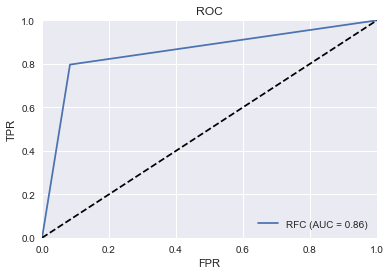

In [54]:
rfc=RandomForestClassifier(criterion='entropy')
rfc.fit(trainX[['price','enc_country','enc_province','enc_variety','textlen']],trainY['over90'])
rfc_preds=rfc.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']])
print(rfc.score(testX[['price','enc_country','enc_province','enc_variety','textlen']],testY['over90']))
plotAUC(testY['over90'],rfc.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']]),'RFC')

## Gradient Boosted Classifier

0.8005161979352082


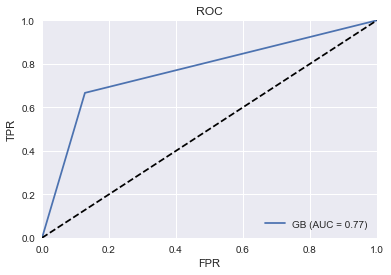

In [53]:
gbc=GradientBoostingClassifier()
gbc.fit(trainX[['price','enc_country','enc_province','enc_variety','textlen']],trainY['over90'])
gbc_preds=gbc.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']])
print(gbc.score(testX[['price','enc_country','enc_province','enc_variety','textlen']],testY['over90']))
plotAUC(testY['over90'],gbc.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']]),'GB')

## SVM - VERY time consuming

In [ ]:
clf = svm.SVC(kernel='rbf')

In [ ]:
clf.fit(trainX[['enc_country','enc_province','enc_variety','textlen']],trainY['over90'])  

In [ ]:
preds=clf.predict(testX[['enc_country','enc_province','enc_variety','textlen']])

In [ ]:
sum(preds==testY['over90'])/len(testY['over90'])

In [ ]:
q=df['over90'].value_counts().values

In [ ]:
q[0]/sum(q)

In [ ]:
plot_AUC()

## KNN

0.8133677465290139


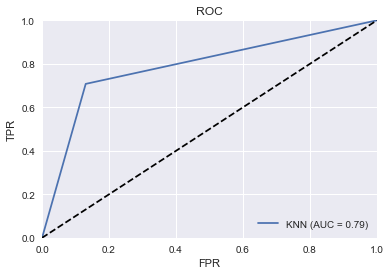

In [52]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(trainX[['price','enc_country','enc_province','enc_variety','textlen']],trainY['over90'])
knn_preds=knn.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']])
print(knn.score(testX[['price','enc_country','enc_province','enc_variety','textlen']],testY['over90']))
plotAUC(testY['over90'],knn.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']]),'KNN')

### Logistic Regression

0.7797614809540762


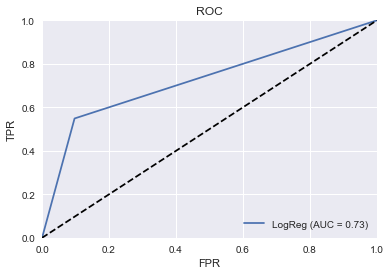

In [55]:
lr = LogisticRegression()
lr.fit(trainX[['price','enc_country','enc_province','enc_variety','textlen']],trainY['over90'])
lr_preds=lr.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']])
print(lr.score(testX[['price','enc_country','enc_province','enc_variety','textlen']],testY['over90']))
plotAUC(testY['over90'],lr.predict(testX[['price','enc_country','enc_province','enc_variety','textlen']]),'LogReg')

### To add later ? Analyze how/why rfc, gbc, and knn prediction are different?

In [56]:
print('RFC and GBC make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==gbc_preds)/len(testY['over90'])))
print('RFC and KNN make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==knn_preds)/len(testY['over90'])))
print('RFC and LR make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==lr_preds)/len(testY['over90'])))
print('GBC and KNN make {0:.2f}% similar predictions'.format(100*sum(gbc_preds==knn_preds)/len(testY['over90'])))
print('GBC and LR make {0:.2f}% similar predictions'.format(100*sum(gbc_preds==lr_preds)/len(testY['over90'])))
print('KNN and LR make {0:.2f}% similar predictions'.format(100*sum(knn_preds==lr_preds)/len(testY['over90'])))

RFC and GBC make 82.82% similar predictions
RFC and KNN make 86.37% similar predictions
RFC and LR make 80.12% similar predictions
GBC and KNN make 83.35% similar predictions
GBC and LR make 90.89% similar predictions
KNN and LR make 80.88% similar predictions
